In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import seaborn as sns
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

In [2]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta, 0)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [3]:
# First, let's define a model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [28]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([1.4])
noise_cov = 0.1*jnp.identity(ndim)
num_samples = 1
data = create_data(model_func, true_theta, noise_cov, num_samples, ndim, prngkey)
print(data)

[[1.5348189]]


In [29]:
# Create Gaussian approximate distribution:
approx_dist = approx_post.distributions.approx.Gaussian(ndim)

In [30]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = 0.1*jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [31]:
reverse_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 16.666847229003906, Params = Jaxtainer({'mean': DeviceArray([-0.1], dtype=float32), 'log_chol_diag': DeviceArray([-0.1], dtype=float32)})
Loss = 12.6978120803833, Params = Jaxtainer({'mean': DeviceArray([-0.1610836], dtype=float32), 'log_chol_diag': DeviceArray([-0.19540268], dtype=float32)})
Loss = 10.637944221496582, Params = Jaxtainer({'mean': DeviceArray([-0.1804936], dtype=float32), 'log_chol_diag': DeviceArray([-0.2842539], dtype=float32)})
Loss = 9.514630317687988, Params = Jaxtainer({'mean': DeviceArray([-0.17742707], dtype=float32), 'log_chol_diag': DeviceArray([-0.3653878], dtype=float32)})
Loss = 8.923554420471191, Params = Jaxtainer({'mean': DeviceArray([-0.16519956], dtype=float32), 'log_chol_diag': DeviceArray([-0.43831116], dtype=float32)})
Loss = 8.651843070983887, Params = Jaxtainer({'mean': DeviceArray([-0.15155865], dtype=float32), 'log_chol_diag': DeviceArray([-0.50304985], dtype=float32)})
Loss = 8.562278747558594, Params = Jaxtainer({'mean': DeviceArray([-0

In [33]:
forward_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 0.0013928820844739676, Params = Jaxtainer({'mean': DeviceArray([-0.09997419], dtype=float32), 'log_chol_diag': DeviceArray([-0.09997019], dtype=float32)})
Loss = 0.0014529937179759145, Params = Jaxtainer({'mean': DeviceArray([-0.04493093], dtype=float32), 'log_chol_diag': DeviceArray([-0.03509241], dtype=float32)})
Loss = 0.0014043169794604182, Params = Jaxtainer({'mean': DeviceArray([0.00011192], dtype=float32), 'log_chol_diag': DeviceArray([0.02625299], dtype=float32)})
Loss = 0.0013882374623790383, Params = Jaxtainer({'mean': DeviceArray([0.02833836], dtype=float32), 'log_chol_diag': DeviceArray([0.05458508], dtype=float32)})
Loss = 0.0013893956784158945, Params = Jaxtainer({'mean': DeviceArray([0.04289727], dtype=float32), 'log_chol_diag': DeviceArray([0.05128642], dtype=float32)})
Loss = 0.0013915877789258957, Params = Jaxtainer({'mean': DeviceArray([0.04241741], dtype=float32), 'log_chol_diag': DeviceArray([0.02851952], dtype=float32)})
Loss = 0.0013936342438682914, Params

Create true posterior:

In [34]:
true_posterior = computation_helpers.construct_true_posterior(model_func, noise_cov, prior_mean, prior_cov,
                                                              theta_lims=(-5,5))

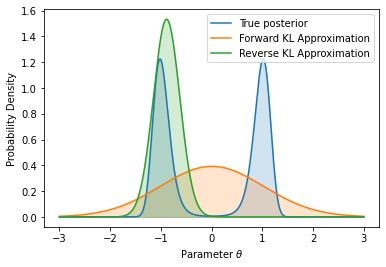

In [36]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
pdfs = {'True posterior': true_posterior(theta_plot, data, 0),
        'Forward KL Approximation': jnp.exp(forward_approx.logpdf(theta_plot)),
        'Reverse KL Approximation': jnp.exp(reverse_approx.logpdf(theta_plot))}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')